In [1]:

import pandas as pd
import numpy as np

from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from scipy.signal import savgol_filter
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import os
import PIL
from PIL import Image
from scipy import misc
from os import listdir
from matplotlib import image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.constraints import max_norm


In [4]:

MIR_spec = pd.read_excel("/content/drive/MyDrive/MIR_Spectra.xlsx", sheet_name = 'MIR')


In [3]:
Prop = pd.read_excel("/content/drive/MyDrive/Properties.xlsx", sheet_name = 'Properties')

In [5]:

MIR_spec.head()


,SSN,m7498,m7496,m7494.1,m7492.2,m7490.3,m7488.3,m7486.4,m7484.5,m7482.5,m7480.6,m7478.7,m7476.8,m7474.8,m7472.9,m7471,m7469,m7467.1,m7465.2,m7463.3,m7461.3,m7459.4,m7457.5,m7455.5,m7453.6,m7451.7,m7449.8,m7447.8,m7445.9,m7444,m7442,m7440.1,m7438.2,m7436.3,m7434.3,m7432.4,m7430.5,m7428.5,m7426.6,m7424.7,...,m675,m673,m671.1,m669.2,m667.3,m665.3,m663.4,m661.5,m659.5,m657.6,m655.7,m653.8,m651.8,m649.9,m648,m646,m644.1,m642.2,m640.3,m638.3,m636.4,m634.5,m632.5,m630.6,m628.7,m626.8,m624.8,m622.9,m621,m619,m617.1,m615.2,m613.3,m611.3,m609.4,m607.5,m605.5,m603.6,m601.7,Unnamed: 3578
0,FS15R_FS4747,NaN,0.249664,0.245713,0.250524,0.258732,0.258520,0.247956,0.240024,0.239718,0.238868,0.238551,0.243440,0.250412,0.256919,0.260620,0.257912,0.252869,0.251574,0.248359,0.238483,0.229296,0.228252,0.235075,0.242389,0.243526,0.240001,0.238771,0.242473,0.241865,0.233572,0.229338,0.230220,0.226124,0.219652,0.218659,0.222325,0.228751,0.240220,0.251818,...,1.358203,1.356669,1.355461,1.352019,1.349838,1.350696,1.350501,1.349473,1.349136,1.350319,1.353780,1.358559,1.363183,1.368180,1.373795,1.379624,1.385777,1.391954,1.397509,1.402261,1.406105,1.408498,1.409152,1.408881,1.409503,1.411631,1.413638,1.414604,1.414798,1.414448,1.413749,1.411837,1.407290,1.400203,1.392564,1.385839,1.381001,1.378734,1.376351,NaN
1,FS15R_FS4748,NaN,0.420339,0.416489,0.421274,0.429575,0.429741,0.419711,0.411995,0.411414,0.410272,0.410046,0.415241,0.422256,0.428355,0.431559,0.428770,0.423874,0.422416,0.419082,0.409654,0.401085,0.400256,0.406960,0.414224,0.415526,0.412187,0.410915,0.414380,0.413719,0.405666,0.401473,0.402054,0.397806,0.391520,0.390750,0.394425,0.400745,0.412032,0.423291,...,1.219234,1.217161,1.215094,1.212197,1.211971,1.214380,1.215181,1.215245,1.216576,1.218877,1.221604,1.224915,1.228434,1.232666,1.238884,1.246014,1.251694,1.255859,1.259511,1.263024,1.266644,1.269952,1.272484,1.275251,1.278969,1.282538,1.285538,1.288289,1.291079,1.294800,1.299143,1.302645,1.303650,1.302277,1.301182,1.300110,1.296567,1.293431,1.294753,NaN
2,FS15R_FS4068,NaN,0.351148,0.349066,0.362320,0.376014,0.371365,0.354477,0.345498,0.344658,0.343924,0.346313,0.353067,0.360932,0.368013,0.369928,0.364596,0.360283,0.360122,0.355152,0.345639,0.340469,0.342268,0.348376,0.352751,0.351216,0.347256,0.347442,0.350655,0.348202,0.341673,0.339979,0.339774,0.335103,0.330677,0.330751,0.333292,0.339797,0.352346,0.360700,...,1.635133,1.637715,1.638377,1.638343,1.643271,1.649285,1.652993,1.657021,1.660948,1.663625,1.664113,1.661960,1.660158,1.659923,1.659183,1.659032,1.660988,1.663360,1.666011,1.669315,1.672217,1.675091,1.677890,1.679014,1.678589,1.678673,1.680558,1.683728,1.684193,1.678957,1.671718,1.665174,1.655418,1.639435,1.619725,1.601411,1.587548,1.578279,1.571200,NaN
3,FS15R_FS4069,NaN,0.262369,0.260346,0.273859,0.287886,0.283264,0.265931,0.256772,0.256205,0.255447,0.257474,0.264329,0.272939,0.280705,0.282755,0.277128,0.272449,0.272086,0.267015,0.257487,0.252459,0.254425,0.260593,0.265137,0.263937,0.260074,0.260125,0.263320,0.260954,0.254525,0.252889,0.252682,0.248092,0.243812,0.243987,0.246702,0.253460,0.266227,0.274895,...,1.759039,1.760727,1.763177,1.762189,1.761425,1.767289,1.774347,1.779990,1.784055,1.785028,1.781726,1.776414,1.770483,1.766495,1.767058,1.768413,1.767426,1.767699,1.770568,1.772418,1.772385,1.771608,1.768956,1.765491,1.762439,1.757682,1.752639,1.750718,1.746873,1.737878,1.727458,1.716915,1.705238,1.688797,1.667594,1.648464,1.633849,1.622770,1.613260,NaN
4,FS15R_FS4070,NaN,0.262863,0.260787,0.274102,0.287959,0.283258,0.265950,0.256692,0.255892,0.255145,0.257447,0.264481,0.272988,0.280602,0.282738,0.277332,0.272827,0.272644,0.267570,0.257508,0.251827,0.253729,0.260255,0.265035,0.263927,0.260238,0.260488,0.263763,0.261277,0.254428,0.252332,0.252125,0.247916,0.243826,0.243905,0.246592,0.253396,0.266105,0.274618,...,1.795598,1.796577,1.795683,1.795020,1.802995,1.812782,1.817204,1.819699,1.821266,1.820475,1.817397,1.812436,1.806177,1.800963,1.799182,1.800474,1.802281,1.804395,1.808184,

In [6]:

# remove columns with NaN 
MIR_spec.dropna(axis=1, inplace = True)
# count Na values in dataframe
MIR_spec.isnull().sum().sum()


0

In [7]:

# Select the soil property

ref = input('Select a soil property between pH (H2O), Org C, Org N, Mg, Na, K, Tot Si, Clay')


Select a soil property between pH (H2O), Org C, Org N, Mg, Na, K, Tot Si, ClaypH (H2O)


In [8]:

Prop.rename(columns = {'Batch and labid' : 'SSN'}, inplace=True)
Y = Prop[['SSN', ref]]

# Group the spectra and Y with same SSN and then calculate their average

MIR_spec = MIR_spec.groupby('SSN').mean()
Y=Y.groupby('SSN').mean()

In [9]:

# Group the spectra and Y with same SSN and then calculate their average

MIR_spec = MIR_spec.groupby('SSN').mean()
Y=Y.groupby('SSN').mean()


In [10]:

# Merge rows with same SSN value

Y_MIR = Y.merge(MIR_spec, on=["SSN"])

Y_MIR.dropna(axis=0, inplace=True)

In [11]:

# split data into cal and val

Y_MIR.sort_values(by=[ref], ascending = True, inplace = True)

Y_MIR_pred =[]
for j in range(0,len(Y_MIR),4):
   Y_MIR_pred.append(Y_MIR.iloc[j,:])

Y_MIR_pred=pd.DataFrame(Y_MIR_pred)
Y_MIR_Cal = Y_MIR.drop(Y_MIR_pred.index)
Y_MIR_Cal2 = Y_MIR_Cal.drop([ref], axis=1)

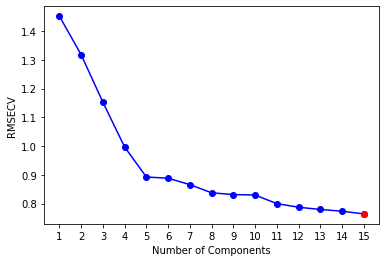

In [16]:

# PLS regression

rmsecv_all = []
ncomp = 15

for k in range(1,ncomp+1):
    pls = PLSRegression(n_components = k)

    pls.fit(Y_MIR_Cal2, Y_MIR_Cal[[ref]])

    y_cv = cross_val_predict(pls, Y_MIR_Cal2,
                         Y_MIR_Cal[[ref]], cv=10)

    rmse_cv = (mean_squared_error(Y_MIR_Cal[[ref]], y_cv))**(0.5)

    rmsecv_all.append(rmse_cv)


ncomp_rmsecv = pd.concat([pd.DataFrame(range(1, ncomp+1))
                           ,pd.DataFrame(rmsecv_all)],axis=1, 
                          ignore_index=True)
ncomp_rmsecv.columns=['ncomp','RMSECV']


plt.plot( ncomp_rmsecv['ncomp'], ncomp_rmsecv['RMSECV'], marker='o', 
         color='blue')
plt.plot( ncomp_rmsecv['ncomp'][ncomp_rmsecv['RMSECV'].idxmin()],
         ncomp_rmsecv['RMSECV'].min(), marker='o', 
         color='red')
plt.xlabel('Number of Components')
plt.ylabel('RMSECV')
plt.xticks(range(1, ncomp+1));


In [17]:

# Select the model with best ncomp and use it to predict independent samples

ncomp_final = ncomp_rmsecv['RMSECV'].idxmin() + 1
pls_final = PLSRegression(n_components = ncomp_final)
pls_final.fit(Y_MIR_Cal2, Y_MIR_Cal[[ref]])
y_pred = pls_final.predict(Y_MIR_pred.drop([ref], axis=1))
rmse_pred = (mean_squared_error(Y_MIR_pred[[ref]], y_pred))**(0.5)
score_pred = r2_score(Y_MIR_pred[[ref]], y_pred)
print('RMSE pred: %5.3f' % rmse_pred)
print('R2 pred: %5.3f'  % score_pred)

RMSE pred: 0.652
R2 pred: 0.785


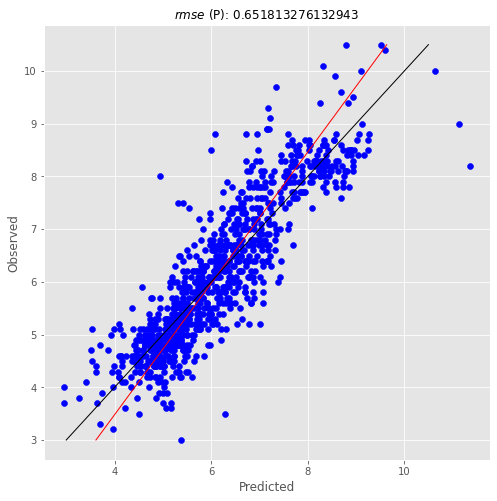

In [22]:

# Fit a line to the CV vs response
z = np.polyfit(Y_MIR_pred[ref], y_pred,1)
    
with plt.style.context(('ggplot')):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.scatter(y_pred, Y_MIR_pred[[ref]], c='blue')
            
ax.plot(np.polyval(z,Y_MIR_pred[ref]), Y_MIR_pred[[ref]], c='red', linewidth=1)
 #Plot the  line
ax.plot(Y_MIR_pred[[ref]], Y_MIR_pred[[ref]], color='black', linewidth=1)
plt.title('$rmse$ (P): ' +str(rmse_pred))
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.show()